Geopandas setup:
On Linux, you can type the following:
    
`sudo apt-get install python-dev
sudo apt-get install libgdal1-dev
sudo apt-get install gdal-bin
sudo apt-get install python-gdal
sudo pip install git+git://github.com/geopandas/geopandas.git`

Note that I have installed GeoPandas from the GitHub source, I had trouble with the normal packaged version.

In [1]:
import pandas as pd
import numpy as np
import os
import urllib
import zipfile

import geopandas as gp
from geopandas.plotting import plot_dataframe
from shapely.geometry import Polygon,Point, LineString

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# 1. Download and import map data

### a. [either] JSON

In [2]:
urllib.urlretrieve("https://github.com/datasets/geo-countries/raw/master/data/countries.geojson",
                  "countries.geojson")

('countries.geojson', <httplib.HTTPMessage instance at 0x000000000CAFE648>)

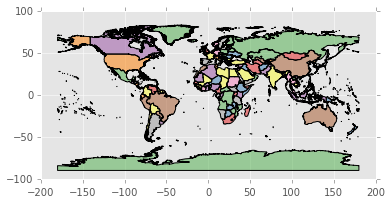

In [3]:
# Import the geojson into geopandas
basemap = gp.read_file('countries.geojson')
basemap.geometry.plot()

### b. [or] SHP

In [4]:
# Retrieve shapefile online
urllib.urlretrieve("http://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip",
                  "ne_10m_admin_0_countries.zip")

# Unzip file and extract contents into a folder
zip_ref = zipfile.ZipFile("ne_10m_admin_0_countries.zip", 'r')
zip_ref.extractall("ne_10m_admin_0_countries") 
zip_ref.close()

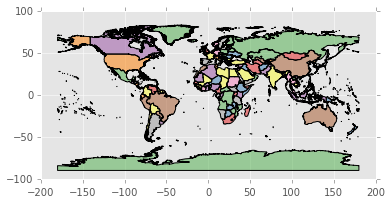

In [5]:
# Import the shapefile into geopandas
basemap = gp.read_file('ne_10m_admin_0_countries') 
basemap.geometry.plot()

### c. [optional] Crop the map to speed up plotting of a small region

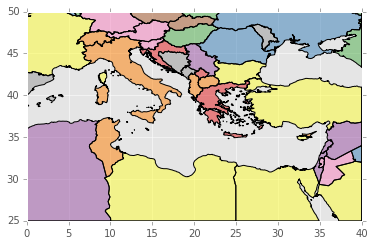

In [6]:
# To speed up plotting, crop the shapefile to our area of interest
xmin, xmax, ymin, ymax = 0, 40, 25, 50
bounds = Polygon([(xmin,ymin), (xmin, ymax), (xmax, ymax), (xmax,ymin)])
basemap['geometry'] = basemap['geometry'].intersection(bounds)
basemap.geometry.plot()

# 2. Plot

### a. Base map

(25, 50)

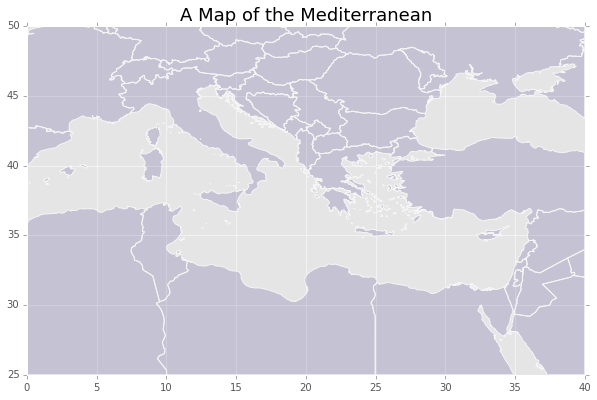

In [7]:
ax = basemap.plot(color='darkslateblue',
             alpha=0.2,
             edgecolor='whitesmoke',
             figsize=(10,10))

ax.set_title("A Map of the Mediterranean", size=18)
ax.set_xlim([0,40])
ax.set_ylim([25,50])

### b. Add a box

In [8]:
xmin, xmax, ymin, ymax = 9.8, 35, 29.8, 42.2 
bounds = Polygon([(xmin,ymin), (xmin, ymax), (xmax, ymax), (xmax,ymin)])
box_x,box_y = bounds.exterior.xy

(25, 50)

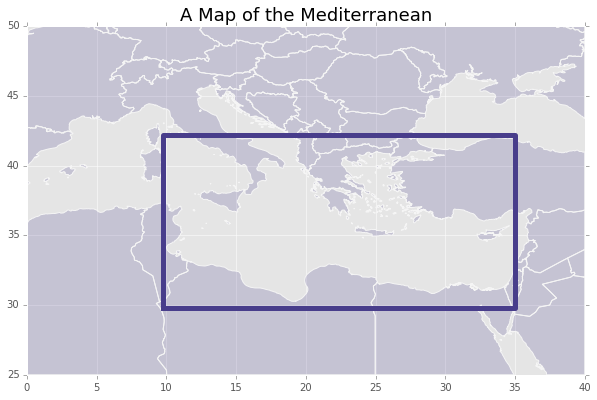

In [9]:
ax = basemap.plot(color='darkslateblue',
             alpha=0.2,
             edgecolor='whitesmoke',
             figsize=(10,10))

# Draw box
ax.plot(box_x,box_y, linewidth = 5, color='darkslateblue')

ax.set_title("A Map of the Mediterranean", size=18)
ax.set_xlim([0,40])
ax.set_ylim([25,50])

### c. Add annotated points

In [10]:
# Initialize dataframe with port coordinates [alternatively - you can read a dataframe in from CSV]
ports = pd.DataFrame({'port': ['Valetta', 'Lampedusa', 'Tripoli'],
                      'lat': [35.898434, 35.508600, 32.887200],
                      'lon':[14.504407, 12.592900, 13.191300]             
                     })

# Convert it to a geodataframe
geometry = [Point(xy) for xy in zip(ports.lon, ports.lat)]
ports = gp.GeoDataFrame(ports, geometry=geometry)

(25, 50)

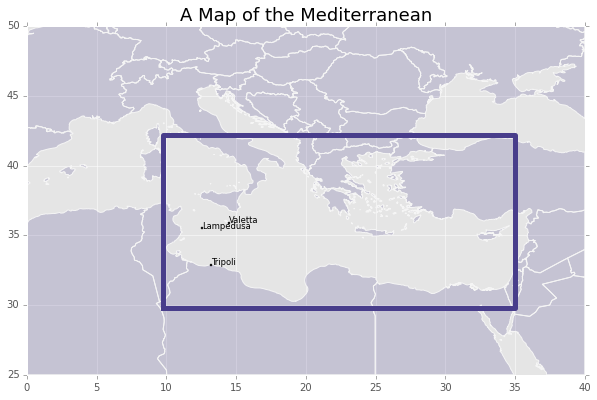

In [11]:
ax = basemap.plot(color='darkslateblue',
             alpha=0.2,
             edgecolor='whitesmoke',
             figsize=(10,10))

# Draw box
ax.plot(box_x,box_y, linewidth = 5, color='darkslateblue')


# Plot points (if not a geodataframe, you can also just plot x,y coords as a scatterplot)
ports.plot(color='black',
             ax = ax )

# Annotate points
for index, row in ports.iterrows():
    ax.text(row.lon+0.01, row.lat-0.03, row.port, fontsize='small')

ax.set_title("A Map of the Mediterranean", size=18)
ax.set_xlim([0,40])
ax.set_ylim([25,50])


### d. Add trajectories

In [12]:
# Initialize dataframe with trajectory coordinates [alternatively - read in a dataframe or shapefile]
path = pd.DataFrame({'path_id': [1,1,1,1,1,2,2,2,3,3],
                      'lat': [33.0,35.5,35.6,35.8,35.4,40.0, 35.8, 34.0, 33.3, 34.0],
                      'lon':[15.1, 15.2, 15.3, 15.4, 15.5, 19.2, 19.5, 21, 17.1, 19.0]             
                     })

# Convert it to a geodataframe
geometry = [Point(xy) for xy in zip(path.lon, path.lat)]
path = gp.GeoDataFrame(path, geometry=geometry)

# Zip points into a linestring
path = path.groupby(['path_id'])['geometry'].apply(lambda x: LineString(x.tolist()))
path = gp.GeoDataFrame(path, geometry='geometry')

(25, 50)

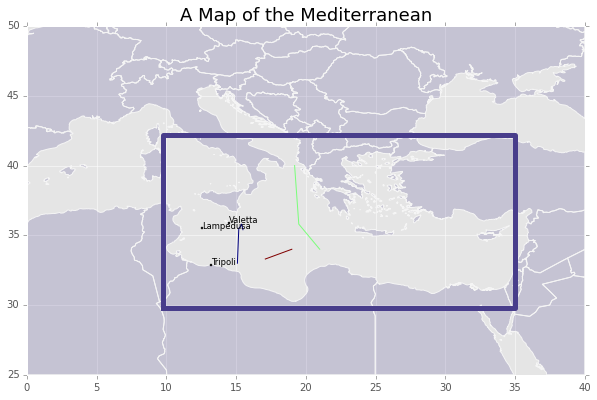

In [13]:
ax = basemap.plot(color='darkslateblue',
             alpha=0.2,
             edgecolor='whitesmoke',
             figsize=(10,10))

# Draw box
ax.plot(box_x,box_y, linewidth = 5, color='darkslateblue')

# Plot points (if not a geodataframe, you can also just plot x,y coords as a scatterplot)
ports.plot(color='black',
             ax = ax )

# Annotate points
for index, row in ports.iterrows():
    ax.text(row.lon+0.01, row.lat-0.03, row.port, fontsize='small')

# Add trajectories (if not a geodataframe, you can also just plot x,y coords as a line)
path.plot(ax=ax)

ax.set_title("A Map of the Mediterranean", size=18)
ax.set_xlim([0,40])
ax.set_ylim([25,50])


# 3. Export a GeoDataFrame to shapefile

In [14]:
path.reset_index().to_file('path.shp', driver='ESRI Shapefile')